In [152]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from astropy.time import Time
import matplotlib.pyplot as plt
import h5py
import re


In [193]:
# define a few functions 
# Adapted from SPCA pipeline

text_objects = []
def create_subplot_names(rows, cols, rowslabel=None, minflux=None, maxflux=None):
    # Create a dictionary to store subplot axes and their names
    subplot_names = {}

    # Create subplots with increased spacing
    fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), sharex=True, sharey=True, figsize=(30, len(rows) * 4))

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust the values as needed
    if minflux is not None and maxflux is not None:
        plt.ylim(minflux, maxflux)

    # Iterate through rows and columns to name the subplots
    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            subplot_name = f"{col}_{row}"  # Switched order to col_row
            ax = axes[i, j]
            subplot_names[subplot_name] = ax

            # Set the title in the middle of each subplot
            # ax.set_title(subplot_name, fontsize=15, x=0.5, y=0.5, loc="center")  # Adjust the fontsize as needed

            # Set row names as labels for y axes for the first column
            if j == 0:
                if rowslabel==None:
                    ax.set_ylabel(row, fontsize=20, labelpad=20)  # Row name as y-axis label
                else:
                    ax.set_ylabel(rowslabel[i], fontsize=20, labelpad=20)  # Row name as y-axis label
            
            # Add "No Model" text to each subplot
            text_obj = ax.text(0.5, 0.45, 'No Model', transform=ax.transAxes,
                             fontsize=18, color='grey', ha='center', va='bottom')  #, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5))
            text_objects.append(text_obj)

    # Set column names at the top of the subplot (not as titles)
    for j, col in enumerate(cols):
        ax = axes[0, j]  # Access the top row of subplots
        ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
        ax.set_xlabel(col, fontsize=20, labelpad=20)  # Column name as x-axis label

    return fig, subplot_names

def calculate_delta_bic(bic_values_dict):
# Get the list of BIC values

    min_bic_key = min(bic_values_dict, key=lambda k: bic_values_dict[k])

    bic_values = list(bic_values_dict.values())
    min_bic = min(bic_values) # Find the minimum BIC value

    # Calculate delta BIC by subtracting the minimum BIC from each BIC value
    delta_bic_values = [bic - min_bic for bic in bic_values]

    # Create a dictionary that maps subplot names to their delta BIC values
    delta_bic_dict = {subplot_name: delta_bic for subplot_name, delta_bic in zip(bic_values_dict.keys(), delta_bic_values)}

    return delta_bic_dict, min_bic_key

def colormap(color=None):
    if color == "rosybrown":
        cmap = LinearSegmentedColormap.from_list('custom_rosybrown', [(0.737, 0.561, 0.561, 0.7), (0.737, 0.561, 0.561, 0)], N=256)
    elif color == "mintgreen":
        cmap = LinearSegmentedColormap.from_list('custom_mintgreen', [(0.678, 0.902, 0.749, 0.8), (0.678, 0.902, 0.749, 0)], N=256)
    elif color == "peach":
        cmap = LinearSegmentedColormap.from_list('custom_peach', [(0.976, 0.729, 0.651, 0.7), (0.976, 0.729, 0.651, 0)], N=256)
    elif color == "macaron_blue":
        cmap = LinearSegmentedColormap.from_list('custom_macaron_blue', [(0.482, 0.686, 0.937, 0.7), (0.482, 0.686, 0.937, 0)], N=256)
    elif color == "amber_orange":
        cmap = LinearSegmentedColormap.from_list('custom_amber_orange', [(1.0, 0.749, 0.0, 0.7), (1.0, 0.749, 0.0, 0)], N=256)
    elif color == "crimson_red":
        cmap = LinearSegmentedColormap.from_list('custom_crimson_red', [(0.863, 0.078, 0.235, 0.7), (0.863, 0.078, 0.235, 0)], N=256)
    elif color == "dark_teal":
        cmap = LinearSegmentedColormap.from_list('custom_dark_teal', [(0.0, 0.204, 0.204, 0.5), (0.0, 0.204, 0.204, 0)], N=256)
    elif color == "terracotta":
        cmap = LinearSegmentedColormap.from_list('custom_terracotta', [(0.796, 0.388, 0.286, 0.7), (0.796, 0.388, 0.286, 0)], N=256)
    elif color == "muted_lavender":
        cmap = LinearSegmentedColormap.from_list('custom_muted_lavender', [(0.655, 0.529, 0.714, 0.6), (0.655, 0.529, 0.714, 0)], N=256)
    elif color == "yellow":
        cmap = LinearSegmentedColormap.from_list('custom_yellow', [(243/255, 187/255, 70/255, 1.0), (243/255, 187/255, 70/255, 0)], N=256)
    else:
        cmap = LinearSegmentedColormap.from_list('custom_crimson_red', [(0.863, 0.078, 0.235, 0.6), (0.863, 0.078, 0.235, 0)], N=256)
    return cmap

def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

def assign_colors_to_bic(bic_values_dict):
    bic_values = list(bic_values_dict.values())

    cmap = colormap(color)

    # Normalize BIC values to [0, 1] for colormap
    norm = plt.Normalize(min(bic_values), max(bic_values))
    
    # Map BIC values to colors
    colors = cmap(norm(bic_values))
    
    # Create a dictionary that maps subplot names to their colors
    bic_colors_dict = {subplot_name: color for subplot_name, color in zip(bic_values_dict.keys(), colors)}
    
    return bic_colors_dict

def plot_model(x, flux, astro, detec, 
               axName=None, bic=None, t_s=None, fp=None,
               savepath='plots/', plotName='Combined_plot_e1.pdf', plotTrueAnomaly=False, nbin=None, background_colors=None, min_subplot=False):   
    
    if nbin is not None:
        x_binned, _ = binValues(x, x, nbin)
        calibrated_binned, calibrated_binned_err = binValues(flux / detec[2][2][2], x, nbin, assumeWhiteNoise=True)
        #residuals_binned, residuals_binned_err = binValues(flux / detec - astro, x, nbin, assumeWhiteNoise=True)
    
    # fig, axes = plt.subplots()
    axes = subplot_dict[axName]

    for text_obj in text_objects:
        if text_obj in axes.texts:
            text_obj.remove()

    print('Mode {} plotted'.format(axName))

    # axes.plot(x, flux / detec, '.', color='k', markersize=4, alpha=0.15)
    axes.plot(x, astro, color='k', linewidth=2, alpha=0.7, zorder=1)
    # add straight line 
    axes.axhline(y=1, ls='--', color='k', alpha=0.7, zorder=200)
    
    if nbin is not None:
        axes.plot(x_binned, calibrated_binned, '.', color='k', markersize=4, alpha=0.15, zorder=2)
    else:
        axes.plot(x, flux/detec, '.', color='k', markersize=4, alpha=0.15, zorder=2)

    fp, fp_errp, fp_errm = fp

    if bic is not None:
        axes.text(0.5, 0.82, r'$\Delta$BIC: {:.2f}'.format(bic), transform=axes.transAxes,
                  fontsize=16, ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5))
        axes.text(
            0.5, 0.64,
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${:.0f}^{:.0f}_{:.0f}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${{:.0f}}^{{+{{:.0f}}}}_{{-{{:.0f}}}}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: {:.0f}^{{+{:.0f}}}_{{-{:.0f}}}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${:.0f}_{{{:.0f}}}^{{+{:.0f}}}$'.format(t_s*60, fp*1e6, fp_errm*1e6, fp_errp*1e6),
            transform=axes.transAxes,
            fontsize=14,
            color='blue',
            ha='center',
            va='bottom',
        )
    axes.set_xticks([])
    axes.set_facecolor(background_colors)


    if min_subplot:
        pos = axes.get_position()
        # Bbox(x0=0.5678571428571428, y0=0.495, x1=0.6785714285714286, y1=0.6875)
   
        macaron_red = (0.929, 0.235, 0.443)
        goldenrod_yellow = (0.855, 0.647, 0.125)  # RGB values

        for spine in axes.spines.values():
            spine.set_edgecolor(macaron_red)  # Set the border color to red
            spine.set_linewidth(5)  # Set the border linewidth
            spine.set_zorder(100)

    if savepath is not None:
        plt.savefig(savepath + plotName, bbox_inches='tight')


    return axes # x, astro, x_binned, calibrated_binned

def plot_rednoise(residuals, minbins, occDuration = None, fname=None, fontsize=10, axName=None,):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    axes = subplot_dict[axName]

    for text_obj in text_objects:
        if text_obj in axes.texts:
            text_obj.remove()

    print('Mode {} plotted'.format(axName))

    axes.set_yscale('log')
    axes.set_xscale('log')
    axes.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS")
    axes.plot(binsz, stderr, c='darkorange', label="Gaussian std.")
    axes.vlines(occDuration, 1e-5, 1e-1, color='black', ls='-.', alpha=0.6, label='Occ. duration')
    ylim = axes.get_ylim()
    # ax.plot([ingrDuration,ingrDuration],ylim, color='black', ls='--', alpha=0.6)
    if occDuration is not None:
        axes.plot([occDuration,occDuration],ylim, color='black', ls='-.', alpha=0.6)
    axes.set_ylim(ylim)
    
    axes.xaxis.set_tick_params(labelsize=fontsize)
    axes.yaxis.set_tick_params(labelsize=fontsize)
    
    plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    plt.ylabel('RMS', fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    if fname is not None:
        plt.savefig(fname)

    return axes

def transit_model(time, t_s, fp):
    params = batman.TransitParams()       #object to store transit parameters[e]
    params.t0 = 58388.7939*24
    params.per = 3.777940*24              #orbital period in hours
    params.rp = 0.0539                    #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def linear_slope(time, m, b):
    return m*time + b

def poly_3rd_degree(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

def double_exponential(time, c1, c2, c3, c4):
    return c1 * np.exp(-c2 * time) + c3 * np.exp(-c4 * time)

def detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6):
    x, y = xdata, ydata
    pos = np.vstack((np.ones_like(x),
                     x   ,      y,
                     x**2, x   *y,      y**2))
    detec = np.array([c1, c2, c3, c4, c5, c6])
    return np.dot(detec[np.newaxis,:], pos).reshape(-1)

def detec_model(time, theta, model_type):
    detec = []
    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF = theta
        detec = exponential_func(time, c1, c2, c3)*linear_slope(time, c4, c5)
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta
        detec = exponential_func(time, c1, c2, c3)
    elif model_type == 'linear':
        t_s, fp, c1, c2, sigF = theta
        detec = linear_slope(time, c1, c2)
    elif model_type == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF = theta
        detec = poly_3rd_degree(time, c1, c2, c3, c4)
    elif model_type == 'double_exp':
        t_s, fp, c1, c2, c3, c4, sigF = theta
        detec = double_exponential(time, c1, c2, c3, c4)
    elif model_type == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF = theta
        detec = exponential_func(time, c1, c2, c3)*poly_3rd_degree(time, c4, c5, c6, c7)
    elif model_type == 'linear+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta
        detec = linear_slope(time, c1, c2)*poly_3rd_degree(time, c3, c4, c5, c6)
    return detec

def signal(time, theta, model_type):
    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF = theta
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta
    elif model_type == 'linear':
        t_s, fp, c1, c2, sigF = theta
    elif model_type == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF = theta
    elif model_type == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF = theta
    elif model_type == 'linear+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta
    astro = transit_model(time, t_s, fp)
    detec = detec_model(time, theta, model_type)
    return astro*detec


In [211]:
eclipses = ['1', '2', '3']
a = '5'
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time_arr = {e: [] for e in eclipses}
aplev_arr = {e: [] for e in eclipses}
aperr_arr = {e: [] for e in eclipses}
centroid_x_arr = {e: [] for e in eclipses}
centroid_y_arr = {e: [] for e in eclipses}


for e in eclipses:
    for seg in segments:
        if e == '1':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif e == '2':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/Stage3/S3_2024-07-22_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif e == '3':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/Stage3/S3_2024-08-05_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time_arr[e] = np.append(time_arr[e], np.array(file['time']))
            aplev_arr[e] = np.append(aplev_arr[e], np.array(file['aplev']))
            aperr_arr[e] = np.append(aperr_arr[e], np.array(file['aperr']))
            centroid_x_arr[e] = np.append(centroid_x_arr[e], np.array(file['centroid_x']))
            centroid_y_arr[e] = np.append(centroid_y_arr[e], np.array(file['centroid_y']))

    time_arr[e] = np.array(time_arr[e])
    aplev_arr[e] = np.array(aplev_arr[e])
    aperr_arr[e] = np.array(aperr_arr[e])
    centroid_x_arr[e] = np.array(centroid_x_arr[e])
    centroid_y_arr[e] = np.array(centroid_y_arr[e])

# eclipses
ecl = {}
ecl['1'] = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
ecl['2']  = Time('2024-07-07 18:34', format = 'iso', scale = 'tdb')
ecl['3']  = Time('2024-07-19 02:34', format = 'iso', scale = 'tdb')

for e in eclipses:
    ecl[e] = ecl[e].mjd
    ecl[e] = ecl[e]-time_arr[e][0]
    ecl[e] = ecl[e]*24 # convert to hours
    print(ecl[e])

e_dur = 1.13 # hours

# Normalize time arrays to start at 0 for each eclipse in hours
for e in eclipses:
    time_arr[e] = (time_arr[e] - time_arr[e][0])*24 


2.3647462059161626
2.3716723350808024
2.353039715671912


In [90]:
# bin the data
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

# retrieve proper errorbars on aplev
def binFluxError(values, error, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binCounts = np.array([np.sum(digitized == i) for i in range(1, nbin)])

    binnedErr = np.array([np.mean(error[digitized == i]) for i in range(1, nbin)])/np.sqrt(binCounts)

    return binned, binnedErr

nbin = 77
bins_time = {e: [] for e in eclipses}
bins_time_err = {e: [] for e in eclipses}
bins_aplev = {e: [] for e in eclipses}
binErr_aplev = {e: [] for e in eclipses}

aperr_norm = {}
bins_aplev_err = {}
aplev_norm = {}
bin_aplev_err = {}
temp = {}

for i, e in enumerate(eclipses): 
    aperr_norm[e] = aperr_arr[e]/np.mean(aplev_arr[e])
    aplev_norm[e] = aplev_arr[e]/np.mean(aplev_arr[e])
    bins_time[e], temp = binValues(time_arr[e], time_arr[e], nbin)
    bins_aplev[e], temp = binValues(aplev_norm[e], time_arr[e], nbin)
    temp, bins_aplev_err[e] = binFluxError(aplev_norm[e], aperr_norm[e], time_arr[e], nbin)

## CHECK THIS



### FIGURE 1: Raw and detrended eclipses

In [ ]:
def extract_mcmc_parameters(file_path):
    # Read the file content
    with open(file_path, "r") as file:
        data = file.read()
    
    # Extract key-value pairs using regular expressions
    results = re.findall(r'(\S+)\s*=\s*([-+]?\d*\.?\d+(?:[e]E][-+]?\d+)?)\s*(\+\d*\.?\d+(?:[e]E][-+]?\d+)?)?\s*(\-\d*\.?\d+(?:[e]E][-+]?\d+)?)?', data)
    
    # Store results in a dictionary
    parameters = {}
    for result in results:
        key = result[0]
        value = float(result[1])
        plus_err = float(result[2]) if result[2] else None
        minus_err = float(result[3]) if result[3] else None
        parameters[key] = {
            "value": value,
            "plus_err": plus_err,
            "minus_err": minus_err
        }
    
    return parameters

#models = ['linear', 'exp', 'exp+linear', 'exp+polynomial', 'polynomial', 'exp_2nd_order_centroid']
#models = ['exp_2nd_order_centroid'] 
parameters = {e: {model: {} for model in models} for e in eclipses}
astro = {e: {model: {} for model in models} for e in eclipses}
detec = {e: {model: {} for model in models} for e in eclipses}
residuals = {e: {model: {} for model in models} for e in eclipses}


## CAN BE SAME OR DIFF MODELS FOR EACH ECL
# for e in eclipses:
#     for model in models:

# if instead of enumerating through the same models for each eclipse, assign a specific model per eclipse
models = ['exp_2nd_order_centroid', 'double_exp_2nd_order_centroid', 'exp_2nd_order_centroid'] #_2nd_order_centroid
for eclipse, e in enumerate(eclipses):
    model = models[eclipse]
    print(model)
    #file = '../ModelComparison/MCMC_results/ecl'+ e + '_' + model + '_results.txt'
    file = '../ModelComparison/MCMC_results/ecl'+ e + '_' + model + '_test_results.txt'
    parameters[e][model] = extract_mcmc_parameters(file)
    print(model, parameters[e][model])
    if model == 'exp':
        t_s, fp, c1, c2, c3, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['exp'].values()]
        detec[e][model] = detec_model(time_arr[e], [t_s, fp, c1, c2, c3, sigF], model)
    elif model == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['exp+linear'].values()]
        detec[e][model] = detec_model(time_arr[e], [t_s, fp, c1, c2, c3, c4, c5, sigF], model)
    elif model == 'linear':
        t_s, fp, c1, c2, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['linear'].values()]
        detec[e][model] = detec_model(time_arr[e], [t_s, fp, c1, c2, sigF], model)
    elif model == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['polynomial'].values()]
        detec[e][model] = detec_model(time_arr[e], [t_s, fp, c1, c2, c3, c4, sigF], model)
    elif model == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['exp+polynomial'].values()]
        detec[e][model] = detec_model(time_arr[e], [t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF], model)
    elif model == 'linear+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['linear+polynomial'].values()]
        detec[e][model] = detec_model(time_arr[e], [t_s, fp, c1, c2, c3, c4, c5, c6, sigF], model)
    elif model == 'double_exp':
        t_s, fp, c1, c2, c3, c4, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['double_exp'].values()]
        detec[e][model] = detec_model(time_arr[e], [t_s, fp, c1, c2, c3, c4, sigF], model)
    elif model == 'exp_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['exp_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x_arr[e], centroid_y_arr[e], c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time_arr[e], [t_s, fp, c7, c8, c9, sigF], 'exp')
        detec[e][model] = detec1 * detec2
    elif model == 'linear+polynomial_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['linear+polynomial_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x_arr[e], centroid_y_arr[e], c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time_arr[e], [t_s, fp, c7, c8, c9, c10, c11, c12, sigF], 'linear+polynomial')
        detec[e][model] = detec1*detec2
    elif model == 'exp+polynomial_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['exp+polynomial_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x_arr[e], centroid_y_arr[e], c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time_arr[e], [t_s, fp, c7, c8, c9, c10, c11, c12, c13, sigF], 'exp+polynomial')
        detec[e][model] = detec1*detec2
    elif model == 'exp+linear_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['exp+linear_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x_arr[e], centroid_y_arr[e], c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time_arr[e], [t_s, fp, c7, c8, c9, c10, c11, sigF], 'exp+linear')
        detec[e][model] = detec1*detec2
    elif model == 'polynomial_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['polynomial_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x_arr[e], centroid_y_arr[e], c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time_arr[e], [t_s, fp, c7, c8, c9, c10, sigF], 'polynomial')
        detec[e][model] = detec1*detec2
    elif model == 'double_exp_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters[e]['double_exp_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x_arr[e], centroid_y_arr[e], c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time_arr[e], [t_s, fp, c7, c8, c9, c10, sigF], 'double_exp')
        detec[e][model] = detec1*detec2

#     astro[model] = transit_model(time_arr[e], t_s, fp)  
#     residuals[model] = (aplev / detec[e][model]) - astro[model]



    astro[e][model] = transit_model(time_arr[e], t_s, fp)  
    residuals[e][model] = (aplev_norm[e] / detec[e][model]) - astro[e][model]

exp_2nd_order_centroid
exp_2nd_order_centroid {'t_s': {'value': 2.353837417693118, 'plus_err': 0.013621238912446376, 'minus_err': -0.013041076622560155}, 'fp': {'value': 0.0003372942260566253, 'plus_err': 5.878540512096157, 'minus_err': None}, 'c_1': {'value': -2.5724076452280684, 'plus_err': 63241.39594860096, 'minus_err': -73672.30089516568}, 'c_2': {'value': -6.389941025254419, 'plus_err': 836.6370086891741, 'minus_err': -633.6379600587137}, 'c_3': {'value': 6.525492587736043, 'plus_err': 428.07350939766724, 'minus_err': -528.0972433662946}, 'c_4': {'value': 0.7233170877339714, 'plus_err': 2.1655761058799317, 'minus_err': -2.382012562652389}, 'c_5': {'value': -1.4045958036658905, 'plus_err': 2.3074510744156838, 'minus_err': -2.5406152714541657}, 'c_6': {'value': 0.6804574248204798, 'plus_err': 1.2135143668648027, 'minus_err': -1.130463461237509}, 'c_7': {'value': 0.0032785998747512667, 'plus_err': 0.0002020955626869385, 'minus_err': -0.00020261867098205887}, 'c_8': {'value': 2.12042

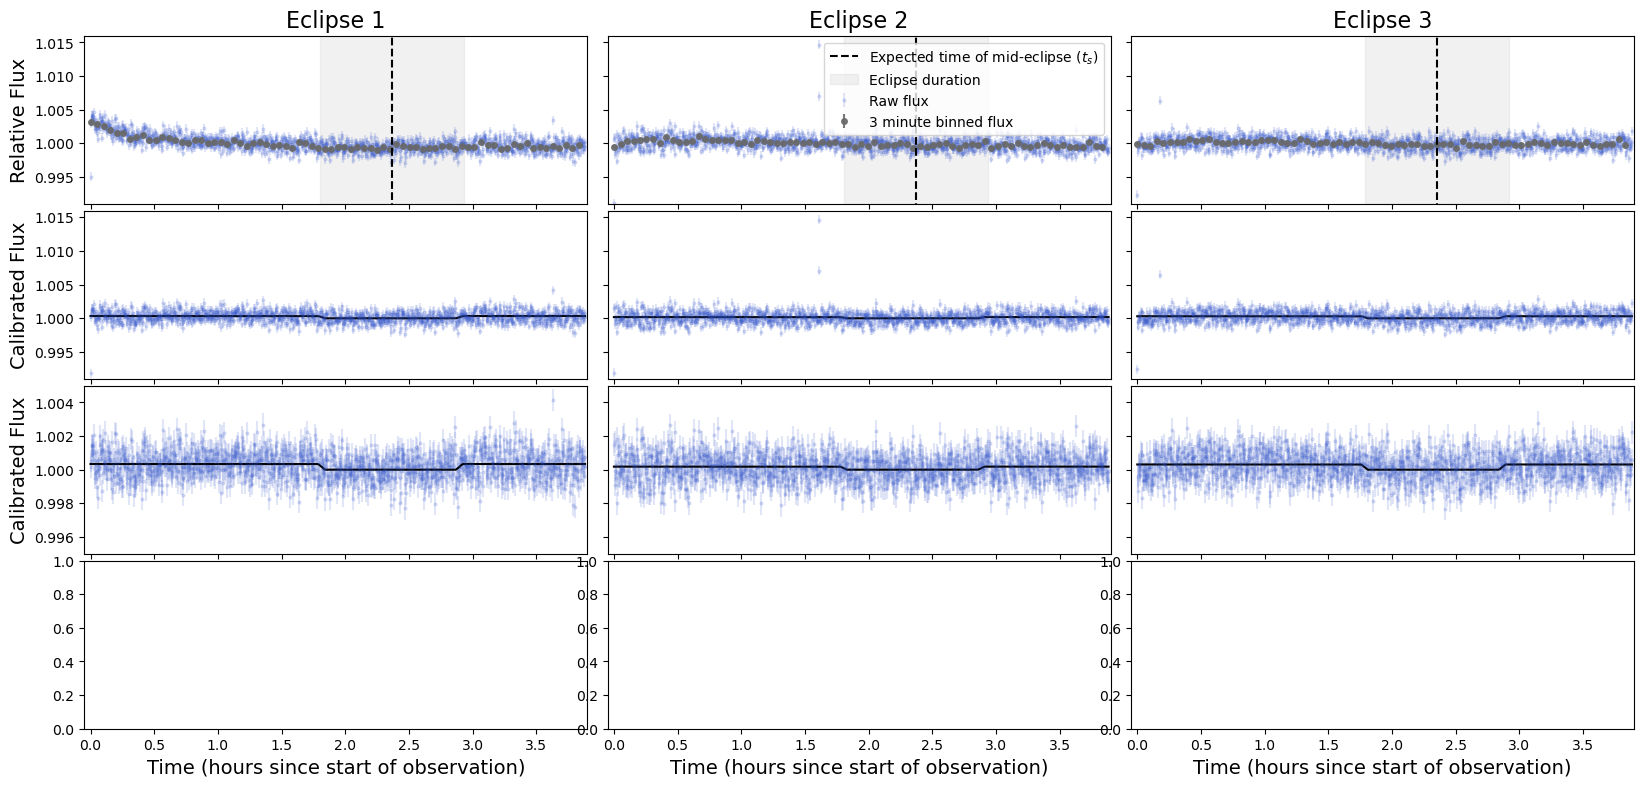

In [267]:
fig, ax = plt.subplots(4, 3, figsize=(20, 9),sharex=True)

for i, e in enumerate(eclipses):
    model = models[i]
    ax[0,i].errorbar(time_arr[e], aplev_norm[e], yerr=aperr_norm[e], fmt='o', label='Raw flux', alpha=0.15, color='#3355cc', markersize = 2, zorder=2)
    # error bar marker size
    ax[0,i].vlines(ecl[e], 0.99, 1.02, color='black', linestyle='--', label='Expected time of mid-eclipse $(t_s)$', zorder=3)
    ax[0,i].axvspan(ecl[e]-e_dur/2, ecl[e]+e_dur/2, color='lightgrey', alpha=0.3, label = 'Eclipse duration', zorder=0)
    ax[0,i].errorbar((bins_time[e]-bins_time[e][0])*24, bins_aplev[e], yerr=bins_aplev_err[e], fmt='o', alpha=0.9, color='dimgrey',markersize = 4, label='3 minute binned flux')
    ax[1,i].errorbar(time_arr[e], aplev_norm[e]/detec[e][model], yerr=aperr_norm[e], fmt='o', label='Raw flux', alpha=0.15, color='#3355cc', markersize = 2, zorder=2)
    ax[1,i].plot(time_arr[e], astro[e][model], '-', color='k')
    ax[2,i].errorbar(time_arr[e], aplev_norm[e]/detec[e][model], yerr=aperr_norm[e], fmt='o', label='Raw flux', alpha=0.15, color='#3355cc', markersize = 2, zorder=2)
    ax[2,i].plot(time_arr[e], astro[e][model], '-', color='k')

# ax[1,0].plot(time_arr[e], aplev_norm[e], 'o', color='r', markersize=2)
# ax[1,0].plot(time_arr[e], aplev_norm[e]/detec[model], 'o', color='k', markersize=2)
#     #ax[i].errorbar(bins_time[e], bins_aplev[e], yerr=binErr_aplev[e], label='Binned data', color='black', linestyle='none', alpha=0.5, marker='o', zorder=1)

ax[0,0].set_ylabel('Relative Flux', fontsize=14)
ax[1,0].set_ylabel('Calibrated Flux', fontsize=14)
ax[2,0].set_ylabel('Calibrated Flux', fontsize=14)

# make labelfont size bigger

ax[0,1].legend()
ax[0,0].tick_params(labelbottom=False)
ax[0,1].tick_params(labelbottom=False)

ax[0,0].set_ylim(0.991, 1.016)
ax[0,1].set_ylim(0.991, 1.016)
ax[0,2].set_ylim(0.991, 1.016)

ax[1,0].set_ylim(0.991, 1.016)
ax[1,1].set_ylim(0.991, 1.016)
ax[1,2].set_ylim(0.991, 1.016)

ax[2,0].set_ylim(0.995, 1.005)
ax[2,1].set_ylim(0.995, 1.005)
ax[2,2].set_ylim(0.995, 1.005)


#hide y-ticks
ax[0,1].yaxis.set_ticklabels([])
ax[0,2].yaxis.set_ticklabels([])
ax[1,1].yaxis.set_ticklabels([])
ax[1,2].yaxis.set_ticklabels([])
ax[2,1].yaxis.set_ticklabels([])
ax[2,2].yaxis.set_ticklabels([])

ax[3,0].set_xlabel('Time (hours since start of observation)', fontsize=14)
ax[3,1].set_xlabel('Time (hours since start of observation)', fontsize=14)
ax[3,2].set_xlabel('Time (hours since start of observation)', fontsize=14)

ax[0,0].set_title('Eclipse 1', fontsize=16)
ax[0,1].set_title('Eclipse 2', fontsize=16)
ax[0,2].set_title('Eclipse 3', fontsize=16)

ax[0,2].set_xlim(-0.05, 3.9)

plt.subplots_adjust(hspace=0.04)
plt.subplots_adjust(wspace=0.04)


plt.savefig('../paper-figures/fig1_raw_eclipses.png')
plt.show()

5589.544335762039


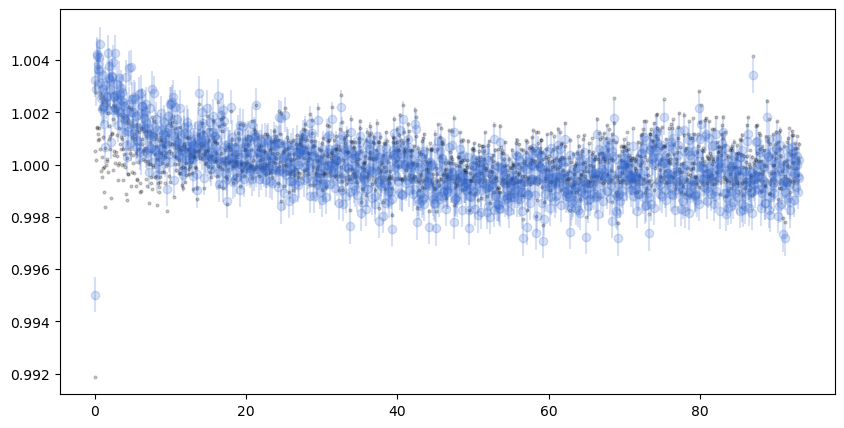

In [215]:
plt.figure(figsize=(10, 5))
plt.errorbar((time_arr['1']-time_arr['1'][0])*24, aplev_norm['1'], yerr=aperr_norm['1'], fmt='o', alpha=0.2, color='#3366cc', label='Eclipse 1')
plt.plot((time_arr['1']-time_arr['1'][0])*24, aplev_norm['1']/detec, 'o', alpha=0.2, color='black', markersize=2, label='Detrended flux')
plt.plot((time_arr['1']-time_arr['1'][0])*24, detec, '-', alpha=0.2, color='black', markersize=2, label='Detrended flux')

#plt.errorbar(bins_time['1'], bins_aplev['1'], yerr=bins_aplev_err['1'], fmt='o', alpha=0.8, color='black', label='Binned data')
# plt.ylim(0.9968, 1.005)
# plt.xlim(0, 3.8)

len(time_arr['1'])
print((time_arr['1'][-1]-time_arr['1'][0])*24*60)

In [86]:
# duration of each observations 232.89768065675162 mins
232.89768065675162/3

77.6325602189172

### FIGURE 2: Detrended fitted eclipses

overlapping corner plot for t_s, fp for 3 eclises / 2 methods